In [1]:
#data
import numpy as np
import pandas as pd
import pdfplumber
import xarray as xr
from pathlib import Path
from typing import Dict, Any

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set_style("whitegrid")

#Bayes
import pymc as pm
import arviz as az
import pytensor.tensor as pt

#Other modules
from bayes import data_utils
#from bayes import load_evidence, HierarchicalModel
#from bayes import DATA_DIR


# Load the evidence

In [30]:
#beta_L_4xCO2,gamma_L_4xCO2,beta_L_2xCO2,gamma_L_2xCO2
process_evidence=data_utils.load_process_evidence(kind="2xCO2")
lookup_table = process_evidence["lookup table"]
emergent_contraint_evidence=data_utils.load_emergent_constraint_evidence()
cmip_evidence=data_utils.load_CMIP_land_data(kind="2xCO2")

evidence = process_evidence | emergent_contraint_evidence | cmip_evidence

In [31]:
cmip_evidence

{'βL_cmip': array([0.6781844 , 1.7183582 , 1.41711329, 0.96955911, 1.36655148,
        1.06912124, 0.9428952 , 1.39863183, 1.06402593, 0.9408827 ,
        1.04856036, 0.86558843, 0.49807927]),
 'γL_cmip': array([ -9.77315605, -88.57084264,  -5.08653616, -12.23552387,
        -51.90008903, -47.31339645,  -7.88489502, -55.1032446 ,
         -0.27209727, -17.15923913, -26.63349592, -18.02130995,
        -11.1362305 ])}

# Set the priors

In [32]:
beta_gamma_priors={"βL":lambda name: pm.Uniform(name,0,10),\
       "γLX": lambda name: pm.Normal(name,-100,100),\
       "γLT": lambda name: pm.Normal(name,-100,100)}

# process priors

#Controls the strength of the beta (Carbon-Concentration) feedback
beta_scaling_priors={"η_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "η_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δβ_permafrost": lambda name: pm.Normal(name,1.0,.00001),\
            "η_vegetation": lambda name: pm.Uniform(name,0.001,2)}

#Controls the strength of the gamma (Carbon-Climate) feedback.
gamma_scaling_priors={"ν_nitrogen": lambda name: pm.Uniform(name,0.001,1),\
            "ν_fire": lambda name: pm.Uniform(name,0.001,2),\
            "δγ_permafrost": lambda name: pm.Normal(name,-100.0,100),\
            "ν_vegetation": lambda name: pm.Uniform(name,0.001,2)}

proc_priors=beta_scaling_priors | gamma_scaling_priors

priors = beta_gamma_priors | proc_priors

# Set the hyperpriors (Or use defaults)
You can think of these as nuisances: they apply to parameters in the forward models we use to make sense of our evidence.  

In [33]:
#Assume model spread in scaling is the same for every process
#This is the PRECISION: 1/sigma (for numerical stability)
#The bigger it is the more representative a single process-based run will be
hyperpriors_process={"τ_eta": lambda name: pm.HalfNormal(name,0.5),\
            "τ_nu": lambda name: pm.HalfNormal(name,0.5)}

# Priors on the slope and y-intercept of the emergent constraint line
hyperpriors_ec = {'m': lambda name: pm.Normal(name,0,10),
        'b': lambda name: pm.Normal(name,0,10)}

# Priors on CMIP model structural spread

#hyperpriors


hyperpriors = hyperpriors_process | hyperpriors_ec
hyperpriors

#OMAR: I AM ADDING THIS BY HAND JUST TO SEE IF IT WORKS, use LKJCholeskyCov
hyperpriors["chol"]= lambda name: pm.LKJCholeskyCov(name, n=2, eta=2, sd_dist=pm.Exponential.dist(1))

# Validate the priors
Make sure we've specified everything we need

In [34]:
data_utils.validate_priors(priors,hyperpriors=hyperpriors)

### Now, we would like to isolate the physical drivers of the carbon cycle feedbacks.

We mathematically calculate exactly how much each specific process (Nitrogen, Fire, Vegetation) contributes to the total result.

The scaling factors are "volume knobs" for specific physical processes, as Chris showed on his slide for priors.



## Use the single-process runs to estimate the scaling factor
Right now we don't know much about the scaling factors because we don't have very many process runs.  The posteriors on $\nu$ and $\gamma$ for each process are going to depend very strongly on two things: 
* our priors on the scaling factors
* how much model spread in the scaling factors we expect there to be

The former is controlled by our physical intuition, as specified above.  The latter is controlled by the $\tau_{process}$ parameter.  If the model spread in the scaling factor is assumed to be small, then even a single process-based run will be very informative about the scaling factor.  If it's big, then a single process-based run tells us almost nothing at all.

The more single-process runs we get, the more we can constrain both the scaling factor and the model spread.

### Caveats
* Right now I assume no cross-correlations between $\eta$ and $\nu$.  It might be reasonable (if more complicated) to assume a model with large $\eta_{N}$ (or whatever) also has large $\gamma_N$.
* I assume a single $\tau_{\nu}$ or $\tau_{\beta}$ for every process.

In [50]:
cmip6_models = ['CMIP6']#], 'CMIP6+'] #hardcoded, but I guess load_process_evidence could return

In [51]:
def make_process_model(model,evidence,priors,hyperpriors):
    
    coords={"process":["nitrogen","fire","vegetation"],\
       "model":cmip6_models,\
        "parameter":["βL","γL"],\
        "cross_parameter":["βL","γL"]}


    with model:
        for k,values in coords.items():
            if k not in model.coords:
                model.add_coord(k,values)
        etalist=[]
        for process in coords["process"]:
            etalist+=[priors[f"η_{process}"](name=f"η_{process}")]
        eta = pm.Deterministic("η",pm.math.stack(etalist),dims=("process",))


        #Assume model spread is the same for every process
        #This is the PRECISION: 1/sigma
        #The bigger it is the more representative a single process-based run will be
       
        tau_eta=hyperpriors["τ_eta"](name="τ_eta")
        tau_nu=hyperpriors["τ_nu"](name="τ_nu")
        #Now update the posteriors for eta_process with the process ensembles
        for k,process in enumerate(coords["process"]):
            pm.Normal("lik_eta_"+process,eta[k],tau=tau_eta,observed=evidence[f"η_{process}"])


        nulist=[]
        for process in coords["process"]:
            nulist+=[priors[f"ν_{process}"](name=f"ν_{process}")]
        nu = pm.Deterministic("ν",pm.math.stack(nulist),dims=("process",))

    # Assume common spread tau_process
    #Now update the posteriors for eta_process with the process ensembles
        for k,process in enumerate(coords["process"]):
            pm.Normal("lik_nu_"+process,nu[k],tau=tau_nu,observed=evidence[f"ν_{process}"])    
    return {"ν":nu,"η":eta, "τ_eta":tau_eta,"τ_nu":tau_nu}

# Emergent constraint model
We use a standard errors-in-variables regression to estimate the slope and y-intercept of the regression between (uncertain) tropical gamma land and (uncertain) interannual variability.  We also take into account the uncertainty in the observed interannual variability.

In [91]:
def make_emergent_constraint_model(model,evidence,priors,hyperpriors):
    with model:
        ### EMERGENT CONSTRAINT ###
        # EMERGENT CONSTRAINT ON TROPICAL γLT
        n_models_EC=len(evidence['γ_LT'])
        
        γLT=priors["γLT"](name="γLT")
            #Assume linear relationships
        # Hyperpriors on slope and intercept
        m = hyperpriors["m"](name="m")
        b = hyperpriors["b"](name="b")

        # Errors-in-variables model for model gammaLT- use standard deviations reported by Zechlau
        x_true = pm.Normal("x_true", mu=evidence['γ_LT'], \
                           sigma=evidence['σ_LT'], \
                           shape=n_models_EC)

        # Linear model for "true IAV" values
        y_true = m * x_true + b

        # Likelihood of observed IAV values
        y_likelihood = pm.Normal("y_obs", mu=y_true, \
                                 sigma=evidence['σ_IAV'],\
                                 shape=n_models_EC,\
                                 observed=evidence['γ_IAV'])
        #Emergent constraint relationship

        mu_obs = m * γLT + b
        # IAV observed ~ N(-4.3,0.67) #CHECK IF THIS IS ONE OR TWO SIGMA
        IAV_true=pm.Normal("IAV_true",mu=mu_obs,\
                           sigma=evidence["IAV_observed_std"],\
                            shape = 1,
                           observed = [evidence["IAV_observed_mean"]]) #[evidence["IAV_observed_mean"]])
        return {"γLT":γLT}

## Note

https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html

```
In past versions of PyMC, there were two types of data containers pymc.Data() and pymc.ConstantData(). These have been deprecated as all data containers are mutable now.
```

In [92]:
#D must have dimensions (Nmodels,2)

D=np.stack([cmip_evidence["βL_cmip"],cmip_evidence["γL_cmip"]]).T


#def covariance_model(model):
with pm.Model() as bigmodel:
    coords={"process":["nitrogen","fire","vegetation"],\
       "model":cmip6_models,\
        "parameter":["βL","γL"],\
        "cross_parameter":["βL","γL"]}
    ########
    #get eta, nu, tau_eta, tau_nu from the process model
    #######
    process_model=make_process_model(bigmodel,
                                     evidence,
                                     priors,
                                     hyperpriors)
    eta=process_model["η"]
    nu=process_model["ν"]
    tau_eta=process_model["τ_eta"]
    tau_nu=process_model["τ_nu"]
    
    ## Add the CMIP data in the form of mutable data
    CMIP = pm.Data("CMIP",D)
    
    
    
    for k,values in coords.items():
            if k not in bigmodel.coords:
                bigmodel.add_coord(k,values)
        
    # Prior on gamma_extratropics
    gamma_extratropics=priors["γLX"](name="γLX")
    # Get gamma tropics from the emergent constraint model
    emergent_constraint_model=make_emergent_constraint_model(bigmodel,\
                                                             evidence,\
                                                             priors,\
                                                             hyperpriors)
    gamma_tropics=emergent_constraint_model["γLT"]
    
    # The total gamma is the sum of extratropics and tropics
    gamma = pm.Deterministic("γL",gamma_extratropics+gamma_tropics)
    # and the prior on beta
    beta=priors["βL"](name="βL")
    mu=pm.Deterministic("μ",pm.math.stack([beta,gamma]),dims=("parameter",))
    
    # Prior on Cholesky decomposition of covariance matrix (has to be LKJ)
    # sd_dist gives priors for standard deviations
    #Make these really wide if you like- reflects model structural spread
    chol, corr, sigma = hyperpriors["chol"](name="chol")

    
    # Construct covariance matrix from Cholesky
    Sigma = pm.Deterministic("Sigma", chol.dot(chol.T),dims=("parameter","cross_parameter"))
   
    #get eta for each model
     
    
    Eta_arr = pt.ones((len(coords["process"]), len(coords["model"])))
    Nu_arr = pt.ones((len(coords["process"]), len(coords["model"])))
    
    for j in range(len(coords["process"])):
        # Use pm.math.switch to multiply by eta[j] only where lookup_table[j, :] == 1
        Eta_arr = pt.set_subtensor(Eta_arr[j, :], 
                                          pm.math.switch(pt.eq(lookup_table[j, :], 1), eta[j], 1.0))
        Nu_arr = pt.set_subtensor(Nu_arr[j, :], 
                                         pm.math.switch(pt.eq(lookup_table[j, :], 1), nu[j], 1.0))
    
    # Unscaled B
    
    B = beta / pm.math.prod(eta)
    G = gamma / pm.math.prod(nu)
 
    
    # Do mu
    mu_model=[]
    for i,model in enumerate(coords["model"]):
       
        eta_model=pm.math.prod(Eta_arr[:,i])
        nu_model=pm.math.prod(Nu_arr[:,i])
        mu_model+=[pm.math.stack([eta_model*B,nu_model*G])]

    mu_totals = pm.Deterministic("all_mus",
                                 pm.math.stack([mu_model[i] for i,model in enumerate(coords["model"])]),
                                              dims=("model", "parameter"))
    
    pm.MvNormal(f'D', mu=mu_totals, chol=chol, observed=CMIP)
    covtrace=pm.sample(target_accept=.99)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: SpecifyShape([0. 0. 0. ... 0. 1. 1.], 1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/omard/Documents/envs/wmo/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omard/Documents/envs/wmo/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omard/Documents/envs/wmo/lib/python3.12/site-packages/pytensor/tensor/rewriting/basic.py", line 1172, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/omard/Do

AssertionError: SpecifyShape: Got shape (13,), expected (1,).

In [85]:
with pm.Model() as bigmodel:
    # 1. Define Coordinates
    coords = {
        "model": cmip6_models,
        "process": ["nitrogen", "fire", "vegetation"],
        "parameter": ["βL", "γL"],
        "cross_parameter": ["βL", "γL"]
    }

    # 2. REGISTER Coordinates with the model BEFORE using them in 'dims'
    for k, values in coords.items():
        if k not in bigmodel.coords:
            bigmodel.add_coord(k, values)

    # 3. Use the Registered Dimensions (and the missing 'parameter' dimension)
    # Note: 'mu_model' must be defined before this line. Assuming it's defined earlier.
    pm.Deterministic("all_mus", 
                     pm.math.stack([mu_model[i] for i, model in enumerate(coords["model"])]),
                     # Include both dimensions: "model" for rows, "parameter" for columns (βL, γL)
                     dims=("model", "parameter"))

In [79]:
with pm.Model() as model:
    test=make_emergent_constraint_model(model,emergent_contraint_evidence,priors,hyperpriors)
    ec_trace=pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γLT, m, b, x_true]


/Users/omard/Documents/envs/wmo/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'γLT'}>

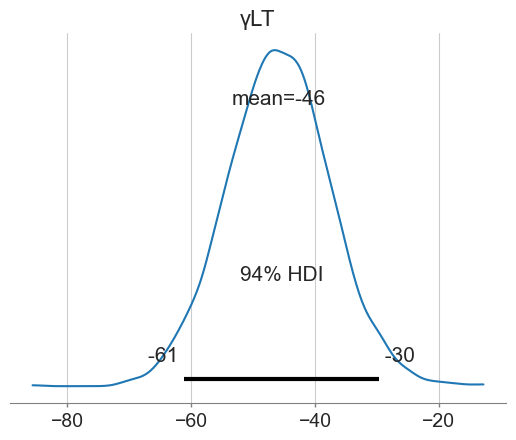

In [108]:
az.plot_posterior(ec_trace,var_names=["γLT"])

In [81]:
with pm.Model() as model:
    test=make_process_model(model,process_evidence,proc_priors,hyperpriors_process)
    process_trace=pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_nitrogen, η_fire, η_vegetation, τ_eta, τ_nu, ν_nitrogen, ν_fire, ν_vegetation]


/Users/omard/Documents/envs/wmo/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [83]:
process_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data